In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Importing files and creating arrays
data = pd.read_csv("input_data/trimmed_data.csv")
print(data.info())
print("\n")
print(data.head())

t = data["sampleNum"]
l = data["label"]
normal_indices = np.array(np.where(l == "Normal")).flatten()
reckless_indices = np.array(np.where(l == "Reckless")).flatten()

a_x_all = data["mean_acc_x"]
a_y_all = data["mean_acc_y"]
a_z_all = data["mean_acc_z"]

a_x_normal = np.array(a_x_all[normal_indices])
a_x_reckless = np.array(a_x_all[reckless_indices])



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sampleNum    948 non-null    int64  
 1   label        948 non-null    object 
 2   std_acc_z    948 non-null    float64
 3   std_acc_x    948 non-null    float64
 4   std_acc_y    948 non-null    float64
 5   mean_acc_z   948 non-null    float64
 6   mean_acc_x   948 non-null    float64
 7   mean_acc_y   948 non-null    float64
 8   range_acc_z  948 non-null    float64
 9   range_acc_x  948 non-null    float64
 10  range_acc_y  948 non-null    float64
dtypes: float64(9), int64(1), object(1)
memory usage: 81.6+ KB
None


   sampleNum   label  std_acc_z  std_acc_x  std_acc_y  mean_acc_z  mean_acc_x  \
0          0  Normal  14.004293  10.351266  14.932545    8.723523   -1.540203   
1          1  Normal  20.583251   9.548827  17.892953    8.417099   -1.356848   
2          2  Normal  22.247468   8.

# Plotting
The following plots can illustrate the differences between normal and reckless driving. Note that the plots are based on all 948 data points, making the differences very clear.

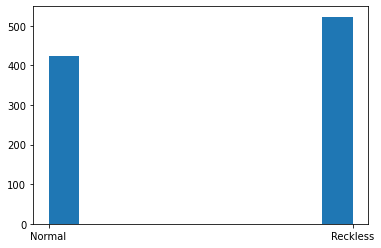

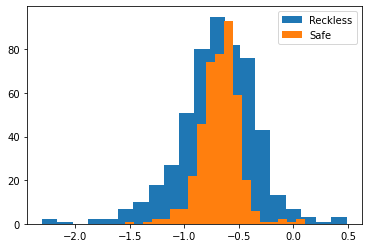

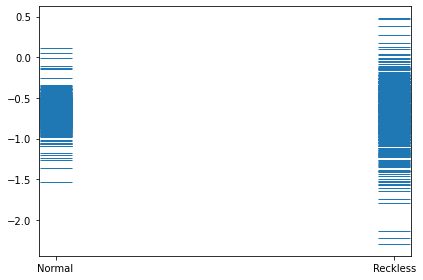

In [3]:
plt.hist(l)
plt.show()

fig, ax = plt.subplots()
ax.hist(a_x_reckless, bins=20, label="Reckless")
ax.hist(a_x_normal, bins=20, label="Safe")
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.scatter(l, a_x_all, s=1000, marker="_", linewidth=1)
fig.tight_layout()
plt.show()


# Finding various statistical quantities:
The data can be studied through some statistical quantities.
Mean, standard deviation and range are expressed above. In addition, we can define energy, entropy and various other quantities which can be used to classify behaviour without using rtificial intelligence.

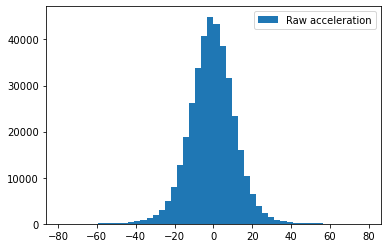

In [4]:
# Using raw data here is probably most sensible.
# The data used above already contains some statistical ariables.
raw_data = pd.read_csv("input_data/raw_data.csv")
a_x_raw = np.array(raw_data["Accelerometer (x) [m/s2]"])
a_y_raw = np.array(raw_data["Accelerometer (y) [m/s2]"])
a_z_raw = np.array(raw_data["Accelerometer (z) [m/s2]"])

fig, ax = plt.subplots()
ax.hist(a_x_raw, bins=50, label="Raw acceleration")
#ax.hist(a_x_normal, label="Safe")
ax.legend()
plt.show()

We can define a number of statistical quantities in order to characterize the behaviour of the rider. Following are some, but others, such as maximun acceleration value, average acceleration value and intensity $\frac{1}{T} \Sigma_t \sqrt{a_x^2 + a_y^2 + a_z^2}$ can be implemented.

In [5]:
# Defining some statistical quantities that can be useful
# If more are needed, they should be defined with a similar
# syntax for simple inclusion in the functions below.
def movement_variation(N, ax, ay, az):
    """Returns variation in acceleration."""
    # I don't know if this is useful, nor if we can expect  it to be.
    # In the sheep paper, it is very unclear if the
    # vectors ax, ay and az are actually supposed to be
    # acceleration vectors.
    dx = np.sum(np.abs(ax[:-1] - ax[1:]))
    dy = np.sum(np.abs(ay[:-1] - ay[1:])) 
    dz = np.sum(np.abs(az[:-1] - az[1:]))
    return (dx + dy + dz)/N

def sma(N, ax, ay, az):
    '''Returns signal magnitude area (SMA) of acceleration'''
    x = np.sum(np.abs(ax))
    y = np.sum(np.abs(ay))
    z = np.sum(np.abs(az))
    return (x + y + z)/N

def entropy(N, ax, ay, az):
    T = np.abs(np.array(ax + ay + az))
    S = np.sum((1+T) * np.log(1+T))
    return S/N

def energy(N, ax, ay, az):
    v = np.array(ax**2 + ay**2 + az**2)
    e = np.sum(v)
    return e/N

In [6]:
# Importing raw data, and separating according to label
raw_t = raw_data["sampleNum"]
raw_l = raw_data["label"]
raw_normal_indices = np.array(np.where(raw_l == "Normal")).flatten()
raw_reckless_indices = np.array(np.where(raw_l == "Reckless")).flatten()

#a_x_all = data["mean_acc_x"]
#a_y_all = data["mean_acc_y"]
#a_z_all = data["mean_acc_z"]

a_x_normal = np.array(a_x_raw[raw_normal_indices])
a_y_normal = np.array(a_y_raw[raw_normal_indices])
a_z_normal = np.array(a_z_raw[raw_normal_indices])
a_x_reckless = np.array(a_x_raw[raw_reckless_indices])
a_y_reckless = np.array(a_y_raw[raw_reckless_indices])
a_z_reckless = np.array(a_z_raw[raw_reckless_indices])

# Number of data points in a segment.
# L = 200 corresponds to one second of data.
L = 400

In [7]:
# Plots the quantities defined above as a function of time
def get_quantity(quantity, ax, ay, az, L):
    N = len(ax)//L
    values = np.zeros(N)
    for i in range(N):
        values[i] = quantity(N, ax[L*i:L*(i+1)], ay[L*i:L*(i+1)], az[L*i:L*(i+1)])
    return values
    
def plot_differences(quantity, ax_n, ay_n, az_n, ax_r, ay_r, az_r, L,save=False):
    N = len(a_x_normal)//L
    M = len(a_x_reckless)//L
    val_n = get_quantity(quantity, ax_n, ay_n, az_n, L)
    val_r = get_quantity(quantity, ax_r, ay_r, az_r, L)

    plt.plot(np.linspace(0, N, len(val_n)), val_n, 'o', markersize=1.4, label="Rolig")
    #plt.plot(np.linspace(0, M, len(val_r)), val_r, 'o', markersize=1.4, label="Utrygg")
    plt.plot(np.linspace(0, M, len(val_r)), np.full(len(val_r), np.mean(val_n)), linestyle="--", color="k", label="Snitt(Rolig)")
    plt.plot(np.linspace(0, M, len(val_r)), val_r - np.mean(val_n), 'o', markersize=1.2, label="Vågal – Snitt(Rolig)")
    plt.plot(np.linspace(0, M, len(val_r)), np.zeros(len(val_r)), linestyle="-", color="k")
    plt.legend(loc="lower right")
    if save:
        plt.title("Forsøk 1, SMA")
        plt.xlabel("Tid")
        plt.ylabel("SMA")
        plt.savefig("klassisk_SMA_1.pdf", format='pdf')
    plt.show()
    print("Mean of normal data:", np.mean(val_n))
    print("Mean of reckless data:", np.mean(val_r))
    print("")

Signal moment magnitude:


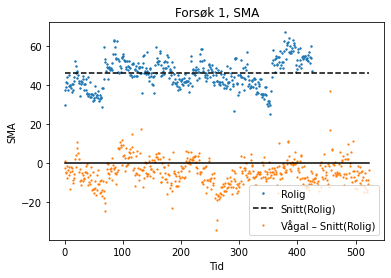

Mean of normal data: 46.12589341236071
Mean of reckless data: 41.3188765740767

Movement variation:


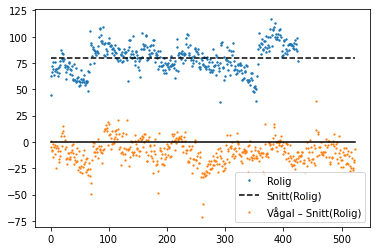

Mean of normal data: 79.52363066836642
Mean of reckless data: 69.72839329283264

Entropy:


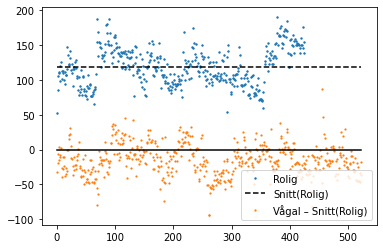

Mean of normal data: 119.29040144698061
Mean of reckless data: 105.26259578158758

Energy:


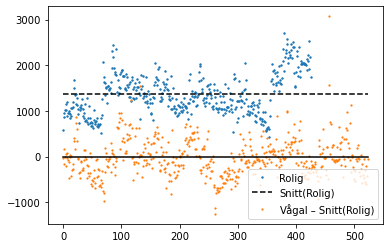

Mean of normal data: 1366.6665777767707
Mean of reckless data: 1346.9224438145245



In [8]:
print("Signal moment magnitude:")
plot_differences(sma, a_x_normal, a_y_normal, a_z_normal, a_x_reckless, a_y_reckless, a_z_reckless, L, save=True)
print("Movement variation:")
plot_differences(movement_variation, a_x_normal, a_y_normal, a_z_normal, a_x_reckless, a_y_reckless, a_z_reckless, L)
print("Entropy:")
plot_differences(entropy, a_x_normal, a_y_normal, a_z_normal, a_x_reckless, a_y_reckless, a_z_reckless, L)
print("Energy:")
plot_differences(energy, a_x_normal, a_y_normal, a_z_normal, a_x_reckless, a_y_reckless, a_z_reckless, L)

From the figures above, it is visible that reckless rides can be separated from normal rides by comparing the deviation of one (or preferably more) of these quantities with the average value of a preprocessed collection of safe rides. The more indicators are above average, the more likely it is that the driver is behaving unsafely.
Including a preprocessed collection of reckless rides in order to make an interval in which it is likely that the driver behaves safely might improve this.

In [9]:
def normal_or_reckless(ax, ay, az, L, means):
    N = len(ax)//L
    vals = get_quantities(ax, ay, az, L)
    recklessness = np.full((N,len(means)), False)
    for i in range(N):
        # reckless - normal > 0:
        recklessness[i,:] = vals[:,i] < means[:]
    return voting(recklessness) 

def voting(A):
    B = A.astype(int)
    B = np.sum(B, axis=1)
    return np.where(B >= 2, True, False)
    
def get_quantities(ax, ay, az, L):
    SMA = get_quantity(sma, ax, ay, az, L)
    MV = get_quantity(movement_variation, ax, ay, az, L)
    S = get_quantity(entropy, ax, ay, az, L)
    E = get_quantity(energy, ax, ay, az, L)
    return np.array([SMA, MV, S, E])[:-1] # Exclude quantities by slicing here.

def get_means(ax, ay, az, L):
    N = len(ax)//L
    vals = get_quantities(ax, ay, az, L)
    means = np.array(np.mean(vals, axis=1))
    return means

# Using this method, the following arrays contain which segments 
# are deemed reckless from the normal and reckless data arrays.
# This means that the array "reckless_segments" should all be true,
# and the array "false_positives" should all be false, ideally.
# Without majority voting, I would expect to get about 50 % true 
# in the false positives array -- corresponding to pure guesswork.
# With majority voting however, the result will hopefully improve.
means_n = get_means(a_x_normal, a_y_normal, a_z_normal, L)
reckless_segments = normal_or_reckless(a_x_reckless, a_y_reckless, a_z_reckless, L, means_n)
false_positives = normal_or_reckless(a_x_normal, a_y_normal, a_y_normal, L, means_n)

tp = np.sum(reckless_segments)/len(reckless_segments)
fp = np.sum(false_positives)/len(false_positives)
tn = 1-fp
fn = 1-tp

#print("Percantage of true positives:\t", 
#      round(reckless_part, 4)*100, "%")
#print("Percentage of false positives:\t",
#      round(normal_part, 4)*100, "%")

accuracy = (tp + tn) / (tp + tn + fp +fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 / ((1/precision) + (1/recall))
fpr = fp / (fp + tn)

#acc = (true_pos*len(reckless_segments) + true_neg*len(false_positives))/(len(reckless_segments) + len(false_positives))
print("accuracy:\t", 
        round(accuracy, 4)*100, "%")
print("Precision:\t", 
        round(precision, 4)*100, "%")
print("Recall:\t\t", 
        round(recall, 4)*100, "%")
print("F1-score:\t", 
        round(f1_score, 4)*100, "%")




accuracy:	 76.36 %
Precision:	 74.78 %
Recall:		 79.54 %
F1-score:	 77.09 %


# Second experiment

<bound method NDFrame.head of                             date  Gyroscope (z) [rad/s]  \
0       2021-02-24T08:19:04.490Z               0.556383   
1       2021-02-24T08:19:04.500Z               0.648936   
2       2021-02-24T08:19:04.510Z               0.722340   
3       2021-02-24T08:19:04.520Z               0.746809   
4       2021-02-24T08:19:04.530Z               0.742553   
...                          ...                    ...   
189595  2021-02-24T10:07:24.654Z               0.692553   
189596  2021-02-24T10:07:24.664Z               0.497872   
189597  2021-02-24T10:07:24.673Z               0.802128   
189598  2021-02-24T10:07:24.683Z               0.890426   
189599  2021-02-24T10:07:24.692Z               0.462766   

        Gyroscope (x) [rad/s]  Gyroscope (y) [rad/s]  temperature [°C]  \
0                    0.014894              -0.019149                25   
1                    0.048936              -0.025532                25   
2                    0.029787          

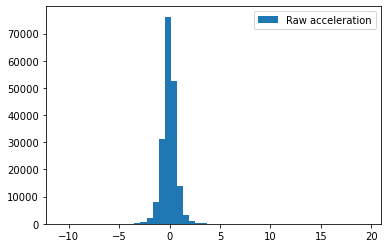

In [15]:
# Using raw data here is probably most sensible.
# The data used above already contains some statistical ariables.
raw_data = pd.read_csv("input_data/trial_1/raw_gyro_data.csv")
print(raw_data.head)
g_x_raw = np.array(raw_data["Gyroscope (x) [rad/s]"])
g_y_raw = np.array(raw_data["Gyroscope (y) [rad/s]"])
g_z_raw = np.array(raw_data["Gyroscope (z) [rad/s]"])

fig, ax = plt.subplots()
ax.hist(g_x_raw, bins=50, label="Raw acceleration")
#ax.hist(a_x_normal, label="Safe")
ax.legend()
plt.show()

# Importing raw data, and separating according to label
raw_t = raw_data["sampleNum"]
raw_l = raw_data["label"]
raw_normal_indices = np.array(np.where(raw_l == "Normal")).flatten()
raw_reckless_indices = np.array(np.where(raw_l == "Reckless")).flatten()

#g_x_all = data["mean_acc_x"]
#g_y_all = data["mean_acc_y"]
#g_z_all = data["mean_acc_z"]

g_x_normal = np.array(g_x_raw[raw_normal_indices])
g_y_normal = np.array(g_y_raw[raw_normal_indices])
g_z_normal = np.array(g_z_raw[raw_normal_indices])
g_x_reckless = np.array(g_x_raw[raw_reckless_indices])
g_y_reckless = np.array(g_y_raw[raw_reckless_indices])
g_z_reckless = np.array(g_z_raw[raw_reckless_indices])

In [43]:
def normal_or_reckless_gyro(ax, ay, az, gx, gy, gz, L, means_a, means_g):
    N = len(ax)//L
    M = len(gx)//L
    vals_a = get_quantities(ax, ay, az, L)
    vals_g = get_quantities(gx, gy, gz, L)
    recklessness = np.full((N,len(means_a) + len(means_g)), False)
    print(recklessness.shape)
    for i in range(N):
        # reckless - normal > 0:
        recklessness[i,:3] = vals_a[:,i] < means_a[:]
        if i % 2 != 0:
            recklessness[i,3:] = vals_g[:,-1+i//2] < means_g[:]
        else:
            recklessness[i,3:] = None
    return voting_gyro(recklessness)

def voting_gyro(A):
    B = A.astype(int)
    B = np.sum(B, axis=1)
    vote = np.full(len(A), True)
    for i in range(len(A)):
        if i % 2 != 0:
            vote[i] = B[i] >= 3
        else:
            vote[i] = B[i] >= 3
    return vote
    
#def get_quantities(ax, ay, az, L):
#    SMA = get_quantity(sma, ax, ay, az, L)
#    MV = get_quantity(movement_variation, ax, ay, az, L)
#    S = get_quantity(entropy, ax, ay, az, L)
#    E = get_quantity(energy, ax, ay, az, L)
#    return np.array([SMA, MV, S, E])[:-1] # Exclude quantities by slicing here.
#
#def get_means(ax, ay, az, L):
#    N = len(ax)//L
#    vals = get_quantities(ax, ay, az, L)
#    means = np.array(np.mean(vals, axis=1))
#    return means

# Using gyroscope only:
means_gn = get_means(g_x_normal, g_y_normal, g_z_normal, L)
g_tpa = normal_or_reckless(g_x_reckless, g_y_reckless, g_z_reckless, L, means_n)
g_fpa = normal_or_reckless(g_x_normal, g_y_normal, g_y_normal, L, means_n)
print("Using only gyroscope:")
g_tp = np.sum(g_tpa)/len(g_tpa)
g_fp = np.sum(g_fpa)/len(g_fpa)
g_tn = 1-fp
g_fn = 1-tp
print(g_tp)
print(g_fp)

print("Using both acceleration and gyroscope:")
means_ng = get_means(g_x_normal, g_y_normal, g_z_normal, L)
means_na = get_means(a_x_normal, a_y_normal, a_z_normal, L)
#means_n = np.stack(means_na, means_ng)
true_positives = normal_or_reckless_gyro(
    a_x_reckless, a_y_reckless, a_z_reckless, 
    g_x_reckless, g_y_reckless, g_z_reckless, L, means_na, means_ng)
false_positives = normal_or_reckless_gyro(
    a_x_normal, a_y_normal, a_z_normal, 
    g_x_normal, g_y_normal, g_y_normal, L, means_na, means_ng)




tp = np.sum(true_positives)/len(true_positives)
fp = np.sum(false_positives)/len(false_positives)
tn = 1-fp
fn = 1-tp

print(tp)
print(fp)

accuracy = (tp + tn) / (tp + tn + fp +fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 / ((1/precision) + (1/recall))
fpr = fp / (fp + tn)


print("accuracy:\t", 
        round(accuracy, 4)*100, "%")
print("Precision:\t", 
        round(precision, 4)*100, "%")
print("Recall:\t\t", 
        round(recall, 4)*100, "%")
print("F1-score:\t", 
        round(f1_score, 4)*100, "%")


Using only gyroscope:
1.0
1.0
Using both acceleration and gyroscope:
(523, 6)
(425, 6)
0.7265774378585086
0.508235294117647
accuracy:	 60.919999999999995 %
Precision:	 58.84 %
Recall:		 72.66 %
F1-score:	 65.02 %


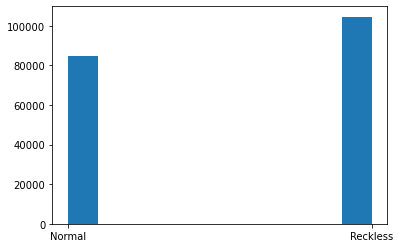

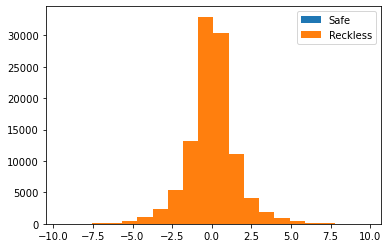

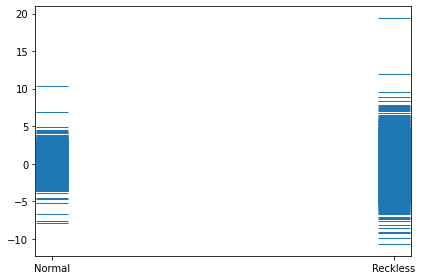

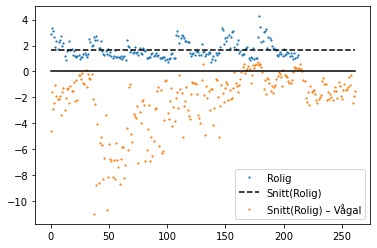

Mean of normal data: 1.6920630070139293
Mean of reckless data: 3.9578554056033584

Signal moment magnitude:
Movement variation:


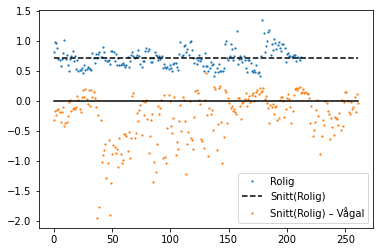

Mean of normal data: 0.7126878460571265
Mean of reckless data: 0.9786788964692676

Signal moment magnitude:
Entropy:


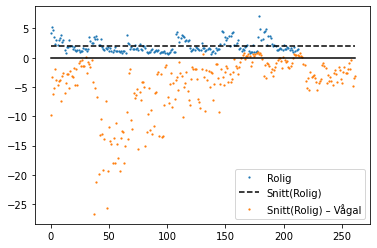

Mean of normal data: 2.0322870742949877
Mean of reckless data: 6.712733206619713

Signal moment magnitude:
Energy:


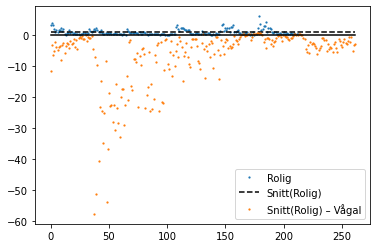

Mean of normal data: 1.0439195016400673
Mean of reckless data: 7.599023996950172

Signal moment magnitude:


In [34]:
t = raw_data["sampleNum"]
l = raw_data["label"]
normal_indices = np.array(np.where(l == "Normal")).flatten()
reckless_indices = np.array(np.where(l == "Reckless")).flatten()

#g_x_raw = np.array(raw_data["Gyroscope (x) [rad/s]"])
#g_y_raw = np.array(raw_data["Gyroscope (y) [rad/s]"])
#g_z_raw = np.array(raw_data["Gyroscope (z) [rad/s]"])

g_x_all = raw_data["Gyroscope (x) [rad/s]"]
g_y_all = raw_data["Gyroscope (y) [rad/s]"]
g_z_all = raw_data["Gyroscope (z) [rad/s]"]

g_x_normal = np.array(g_z_all[normal_indices])
g_x_reckless = np.array(g_z_all[reckless_indices])

plt.hist(l)
plt.show()

fig, ax = plt.subplots()
ax.hist(g_x_normal, bins=20, label="Safe")
ax.hist(g_x_reckless, bins=20, label="Reckless")
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.scatter(l, g_x_all, s=1000, marker="_", linewidth=1)
fig.tight_layout()
plt.show()

# Plots the quantities defined above as a function of time
def get_quantity(quantity, ax, ay, az, L):
    N = len(ax)//L
    values = np.zeros(N)
    for i in range(N):
        values[i] = quantity(N, ax[L*i:L*(i+1)], ay[L*i:L*(i+1)], az[L*i:L*(i+1)])
    return values
    
def plot_differences(quantity, ax_n, ay_n, az_n, ax_r, ay_r, az_r, L, save=False):
    N = len(ax_n)//L
    M = len(ax_r)//L
    val_n = get_quantity(quantity, ax_n, ay_n, az_n, L)
    val_r = get_quantity(quantity, ax_r, ay_r, az_r, L)

    plt.plot(np.linspace(0, N, len(val_n)), val_n, 'o', markersize=1.2, label="Rolig")
    #plt.plot(np.linspace(0, M, len(val_r)), val_r, label="reckless")
    plt.plot(np.linspace(0, M, len(val_r)), np.full(len(val_r), np.mean(val_n)), linestyle="--", color="k", label="Snitt(Rolig)")
    plt.plot(np.linspace(0, M, len(val_r)), np.mean(val_n) - val_r, 'o', markersize=1.2, label="Snitt(Rolig) – Vågal")
    plt.plot(np.linspace(0, M, len(val_r)), np.zeros(len(val_r)), linestyle="-", color="k")
    plt.legend()
    if save:
        plt.title("Forsøk 2, SMA med gyroskop")
        plt.xlabel("Tid")
        plt.ylabel("SMA")
        plt.savefig("klassisk_SMA_gyro_2.pdf", format='pdf')
    plt.show()
    print("Mean of normal data:", np.mean(val_n))
    print("Mean of reckless data:", np.mean(val_r))
    print("")

    print("Signal moment magnitude:")
plot_differences(sma, g_x_normal, g_y_normal, g_z_normal, g_x_reckless, g_y_reckless, g_z_reckless, L)

print("Movement variation:")
plot_differences(movement_variation, g_x_normal, g_y_normal, g_z_normal, g_x_reckless, g_y_reckless, g_z_reckless, L)
print("Entropy:")
plot_differences(entropy, g_x_normal, g_y_normal, g_z_normal, g_x_reckless, g_y_reckless, g_z_reckless, L)
print("Energy:")
plot_differences(energy, g_x_normal, g_y_normal, g_z_normal, g_x_reckless, g_y_reckless, g_z_reckless, L)